Credit and special thanks to the authors of:
https://towardsdatascience.com/an-easy-tutorial-about-sentiment-analysis-with-deep-learning-and-keras-2bf52b9cba91
https://towardsdatascience.com/the-most-favorable-pre-trained-sentiment-classifiers-in-python-9107c06442c6
https://medium.com/@b.terryjack/nlp-pre-trained-sentiment-analysis-1eb52a9d742c

# Data Preprocessing
Mainly removing mails, website links, tokenization (splitting words)

In [11]:
import re
import gensim
from nltk.tokenize.treebank import TreebankWordDetokenizer

In [12]:
def depure_data(data):
    
    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)
        
    return data

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence),     deacc=True))
        
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

def edit_text(text):
    temp = []
    #Splitting pd.Series to list
    data_to_list = [text]
    for i in range(len(data_to_list)):
        temp.append(depure_data(data_to_list[i]))
    data_words = list(sent_to_words(temp))
    data = []
    for i in range(len(data_words)):
        data.append(detokenize(data_words[i]))
    return data[0]

# Flair model initalization

In [13]:
import flair
flair_sentiment = flair.models.TextClassifier.load('en-sentiment')

2022-07-04 09:47:27,165 loading file C:\Users\csaba\.flair\models\sentiment-en-mix-distillbert_4.pt


# Reddit scraping - PRAW

In [14]:
import praw
import numpy as np
reddit = praw.Reddit(client_id='99_Ndr2MqM1qzNw9dmDhuw', client_secret='VnPejgHX9KFQK6jJuf3mMxZkQruxoA', user_agent='sentiment')

In [15]:
import pickle

with open('lsvc_sarcasm.pickle','rb') as f:
    lsvc = pickle.load(f)
with open('tfidf_sarcasm.pickle','rb') as f:
    tfidf = pickle.load(f)    


In [32]:
url = "https://www.reddit.com/r/news/comments/vjpfbh/supreme_court_overturns_roe_v_wade_states_can_ban/"
n_comments = 100

In [33]:
submission = reddit.submission(url=url)
submission.comments.replace_more(limit=0) # flatten tree
comments = submission.comments.list() # all comments

In [34]:
counts = [0, 0]
counts_sarc=[0, 0]

In [35]:
valsFlair = np.zeros(n_comments)
valsFlair_withSarcasm = np.zeros(n_comments)
for i, top_level_comment in enumerate(comments[:n_comments]):
    s = flair.data.Sentence(edit_text(top_level_comment.body))
    flair_sentiment.predict(s)
    total_sentiment = s.labels
    if len(total_sentiment)==1:
        sarcasm = lsvc.predict(tfidf.transform([top_level_comment.body]))[0]
        print(top_level_comment.body + '\n' + str(total_sentiment[0].value)+
              ' '+str(sarcasm)+' '+ str(total_sentiment[0].score)+ '\n')
        result = total_sentiment[0].value
        
        if (result=='NEGATIVE'):
            valsFlair[i]=-1
            counts[0]+=1
            if sarcasm==1:
                valsFlair_withSarcasm[i]=1
                counts_sarc[1]+=1
            else:
                valsFlair_withSarcasm[i]=-1
                counts_sarc[0]+=1
        elif (result=='POSITIVE'):
            valsFlair[i]=1 
            counts[1]+=1
            if sarcasm==1:
                valsFlair_withSarcasm[i]=-1
                counts_sarc[0]+=1
            else:
                valsFlair_withSarcasm[i]=1
                counts_sarc[1]+=1

>In a concurring Dobbs opinion by Justice Clarence Thomas, he says that SCOTUS should "reconsider all of this Court's substantive due process precedents, including Griswold, Lawrence, and Obergefell."  
>  
>That's contraception, same-sex relationships, & same-sex marriage.

[Tweet with opinion text](https://twitter.com/EugeneDaniels2/status/1540341480274944004)
NEGATIVE 0 0.9932112097740173

The Official Decision, [PDF](https://www.supremecourt.gov/opinions/21pdf/19-1392_6j37.pdf)
POSITIVE 0 0.9910848736763

Thomas just said in his concur to reconsider Griswold, Lawrence, and Obergefell. What the hell is happening?
NEGATIVE 0 0.7822279930114746

“The Constitution makes no reference to abortion, and no such right is implicitly protected by any constitutional provision, including the one on which the defenders of Roe and Casey now chiefly rely — the Due Process Clause of the Fourteenth Amendment"  -Judge Alito


How does that jibe with the 9th Amendment, which specifically says a right 

I've lived in the US since I was 10. I am a dual citizen US and German.
I've been in Germany for 6 weeks and am really liking it.

Things like this have me seriously considering leaving the US.
POSITIVE 0 0.9964060187339783

I’m in Texas. We’re fucked.
NEGATIVE 0 0.992782473564148

Susan Collins proved wrong again, two days in a row. Resign now, Susan.
NEGATIVE 0 0.9704383611679077

The real problem with this is that it overturns a long-standing precedent with clearly political motives. If the SC can't uphold a consistent apolitical interpretation of the constitution based on precedent... then our system of government is absolutely broken.

I fear it's over and we just don't know it yet. And in my fucking lifetime.
NEGATIVE 0 0.9993190765380859

“Why is it that most of the people who are against abortion are people you wouldn’t want to fuck in the first place?” -George Carlin
NEGATIVE 0 0.9999494552612305

Glad I live in a liberal state.  This will just further polarize the country.  R

America, land of the free, and home lf the brave.

Women are no longer free.

Your police force are no longer brave enough to stop a school shooter.

It baffles me to imagine some people still look at US exceptionalism and believe in it.
NEGATIVE 0 0.8809113502502441

Huge win for the American Taliban.
POSITIVE 0 0.9066802263259888

I cannot believe this is real
POSITIVE 0 0.5786802768707275

You can’t ban abortions, you can only ban safe abortions.
NEGATIVE 0 0.9752809405326843

To all those who said the worries about *exactly this* happening were alarmist, panicking, silly, overwrought, pearl-clutching - go fuck yourselves.
NEGATIVE 1 0.9997590184211731

For the people cheering that babies will now be saved … what do you think is going to happen to these “saved” babies that are born into unwanted homes ???? Like please answer this because all I see is deflection and taunting by you guys
NEGATIVE 0 0.9516669511795044

FUck fuck fuck fuck fuck fuck fuck fuck fuck fuck fuck fuck fuck fu

Don't be fucking naive. That wouldn't benefit the Republicans at all.
NEGATIVE 0 0.9983850717544556

They’ll go one of two ways, they’ll either hit it from the state level, banning it peicemeal or they’ll say fuck it, drop all pretenses of “State’s Rights” and push for a federal ban.
NEGATIVE 1 0.9997065663337708

"From babies to dead soldiers" - George Carlin
NEGATIVE 0 0.8552080392837524

Now they can laugh at us and tell us we’re stupid and paranoid for thinking criminalizing contraception and homosexuality will be next.
NEGATIVE 0 0.8962662816047668

I’m sure they’ve learned their lessons and won’t do this ever again…

God I hate her…
POSITIVE 1 0.692922830581665

An idiots in her state chose her **again** over someone else.
NEGATIVE 0 0.9984145164489746

But not interracial marriage, despite existing on the same precedent!
NEGATIVE 0 0.5488607287406921



# Visualisation

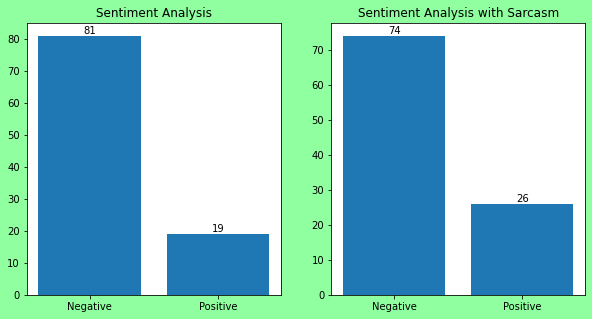

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

bars1=ax1.bar(['Negative', 'Positive'], counts)
bars2=ax2.bar(['Negative', 'Positive'], counts_sarc)
ax1.bar_label(bars1)
ax2.bar_label(bars2)
fig.patch.set_facecolor('xkcd:mint green')
ax1.title.set_text("Sentiment Analysis")
ax2.title.set_text("Sentiment Analysis with Sarcasm")